# Trabalho Prático 2
## Processamento de Linguagem Natural - 2018/2

### Bernardo de Almeida Abreu - 2018718155

## Introdução

A tarefa de realizar um *Part-of-speech tagging* (POS tagging) é uma tarefa clássica da área de processamento de linguagem natural. Ela consiste em assinalar uma classe gramatical para cada token de um texto [1]. Alguns exemplos de classes gramaticais que podem ser atribuídas aos tokens de um texto são "substantivo", "adjetivo" e "pontuação". Muitas vezes uma mesma palavra assume papéis e significados diferentes dependendo do contexto em que se encontra, de modo que essa tarefa não é trivial.

As melhores soluções para esse problema se baseiam em técnicas de aprendizado de máquina supervisionado e, por esse motivo, é necessário que exista uma base de dados anotada na língua correta.

## Implementação

O objetivo desse trabalho é implementar a tarefa de POS-tagging para uma base de dados em português. O corpus utilizado foir o  Mac-Morpho, produzido pelo grupo NILC em da ICMC USP [3]. Essa tarefa foi implementada utilizando uma rede neural para classificar os tokens do texto da base de dados em diferentes classes.

In [113]:
%matplotlib inline
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
import numpy as np
import pandas as pd
import gensim
import keras
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from sklearn.metrics import classification_report

In [123]:
paths = {
    'train': '../macmorpho-v3/macmorpho-train.txt',
    'test': '../macmorpho-v3/macmorpho-test.txt',
    'dev': '../macmorpho-v3/macmorpho-dev.txt',
    'word2vec': '../data/skip_s100.txt',
    'word2vecpickle': '../src/word2vec_model_skipgram_100.p',
}
matplotlib.style.use('seaborn')

### Leitura do texto
O corpus utilzado possui três textos anotados. Cada um deles possui o seu próprio propósito - treino, teste e validação.

In [3]:
def read_text(filename):
    with open(filename, 'r') as f:
        return f.readlines()

In [4]:
train_text = read_text(paths['train'])
test_text = read_text(paths['test'])
dev_text = read_text(paths['dev'])

print(train_text[0])
print(test_text[0])
print(dev_text[0])

Jersei_N atinge_V média_N de_PREP Cr$_CUR 1,4_NUM milhão_N na_PREP+ART venda_N da_PREP+ART Pinhal_NPROP em_PREP São_NPROP Paulo_NPROP ._PU

Salto_N sete_ADJ

Ainda_ADV em_PREP dezembro_N de_PREP 1990_N ,_PU foi_V editada_PCP a_ART famosa_ADJ 289_N ,_PU que_PRO-KS modificava_V a_ART sistemática_N da_PREP+ART arrecadação_N do_PREP+ART ITR_NPROP e_KC alterava_V suas_PROADJ alíquotas_N ._PU



### Separação de palavras e tags
Cada token nos arquivos possui uma *tag* relacionada ao mesmo. Para que se possa fazer o treinamento do modelo de POS-tagging é necessário separar cada token de sua respectiva *tag*.

In [5]:
def split_word_tags(text):
    word_lines = []
    tag_lines = []
    for line in text:
        words, tags = zip(*[tagged_word.split('_') for tagged_word in line.split()])
        word_lines.append([w.lower() for w in words])
        tag_lines.append(list(tags))
    return word_lines, tag_lines

def flat_list(l):
    return [item for sublist in l for item in sublist]

In [6]:
train_words, train_tags = split_word_tags(train_text)
print(train_words[0])
print(train_tags[0])

test_words, test_tags = split_word_tags(test_text)
dev_words, dev_tags = split_word_tags(dev_text)

['jersei', 'atinge', 'média', 'de', 'cr$', '1,4', 'milhão', 'na', 'venda', 'da', 'pinhal', 'em', 'são', 'paulo', '.']
['N', 'V', 'N', 'PREP', 'CUR', 'NUM', 'N', 'PREP+ART', 'N', 'PREP+ART', 'NPROP', 'PREP', 'NPROP', 'NPROP', 'PU']


In [7]:
id2tag = ['<PAD>'] + sorted(list(set(flat_list(train_tags)).union(set(flat_list(test_tags))).union(set(flat_list(dev_tags)))))
tag2id = {}
for i, tag in enumerate(id2tag):
    tag2id[tag] = i

print(id2tag)
print(len(id2tag))

['<PAD>', 'ADJ', 'ADV', 'ADV-KS', 'ART', 'CUR', 'IN', 'KC', 'KS', 'N', 'NPROP', 'NUM', 'PCP', 'PDEN', 'PREP', 'PREP+ADV', 'PREP+ART', 'PREP+PRO-KS', 'PREP+PROADJ', 'PREP+PROPESS', 'PREP+PROSUB', 'PRO-KS', 'PROADJ', 'PROPESS', 'PROSUB', 'PU', 'V']
27


In [8]:
df_train = pd.DataFrame(columns=['words', 'tags'])
df_test = pd.DataFrame(columns=['words', 'tags'])
df_dev = pd.DataFrame(columns=['words', 'tags'])

df_train['words'] = train_words
df_train['tags'] = train_tags

df_test['words'] = test_words
df_test['tags'] = test_tags

df_dev['words'] = dev_words
df_dev['tags'] = dev_tags

df_sentences = pd.concat([df_train, df_test, df_dev], axis=0)

### Padding das sentenças
A entrada da rede neural deve ser de um tamanho fixo. Para que as diferentes sentenças presentes no corpus, que podem possuir tamanhos distintos entre si, possam ser fornecidas como entrada para a rede, é necessário padronizar o tamanho das mesmas. Essa padronização é feita através de dois passos, remover as palavras extras da sentenças que ultrapassam o tamanho definido, e adicionar um token de *padding* às sentenças que possuem um comprimento menor do que o tamanho determinado, que é então repetido até que a sentença atinja o tamanho correto.

Esse tamanho foi determinado de acordo com a distribuição dos tamanhos das sentenças ao longo do corpus. Para obter um compromisso entre sentenças com muito *padding* e sentenças que devem ter palavras removidas, o tamanho foi definido como aquele que evita eliminar palavras de 75% de todas as sentenças do corpus, incluindo as bases de treino, validação e teste.

In [9]:
df_sentences['words'].map(len).describe()

count    49932.000000
mean        18.940779
std         12.070051
min          1.000000
25%         10.000000
50%         17.000000
75%         25.000000
max        248.000000
Name: words, dtype: float64

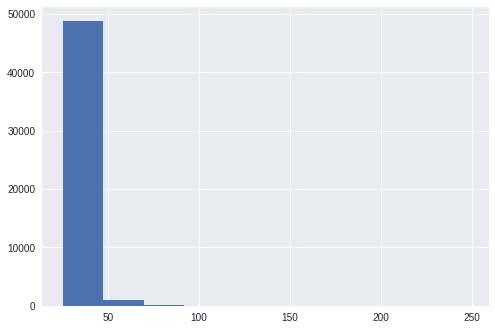

In [124]:
df_sentences['words'].map(len).hist()
plt.show()

In [11]:
MAX_SENTENCE_LENGTH = int(df_sentences['words'].map(len).describe()['75%'])
MAX_SENTENCE_LENGTH

25

In [12]:
def fill_sentence(sentence):
    tokens_to_fill = int(MAX_SENTENCE_LENGTH - len(sentence))
    sentence.extend(['<PAD>']*tokens_to_fill)
    
    return sentence[:MAX_SENTENCE_LENGTH]

In [13]:
df_train["words"] = df_train["words"].map(fill_sentence)
df_train["tags"] = df_train["tags"].map(fill_sentence)

df_test["words"] = df_test["words"].map(fill_sentence)
df_test["tags"] = df_test["tags"].map(fill_sentence)

df_dev["words"] = df_dev["words"].map(fill_sentence)
df_dev["tags"] = df_dev["tags"].map(fill_sentence)

In [14]:
df_test.head()

,words,tags
0,"[salto, sete, <PAD>, <PAD>, <PAD>, <PAD>, <PAD...","[N, ADJ, <PAD>, <PAD>, <PAD>, <PAD>, <PAD>, <P..."
1,"[o, grande, assunto, da, semana, em, nova, yor...","[ART, ADJ, N, PREP+ART, N, PREP, NPROP, NPROP,..."
2,"[número, duplo, especial, ,, é, inteirinho, de...","[N, ADJ, ADJ, PU, V, ADJ, PCP, PREP, N, PREP, ..."
3,"[a, endiabrada, editora, tina, brown, ex, da, ...","[ART, PCP, N, NPROP, NPROP, N, PREP+ART, PU, N..."
4,"[além, das, fotos, de, richard, avedon, ., <PA...","[PREP, PREP+ART, N, PREP, NPROP, NPROP, PU, <P..."


In [15]:
df_dev['words'].map(len).describe()

count    1997.0
mean       25.0
std         0.0
min        25.0
25%        25.0
50%        25.0
75%        25.0
max        25.0
Name: words, dtype: float64

### Embedding - Word2Vec
A representação das palavras na rede neural foi feita através do modelo word2vec. Para isso, foi escolhido um embedding já treinado em português, produzido pelo grupo NILC em da ICMC USP [4] O embedding escolhido foi treinado através do skip-gram e possui vetores de tamanho 100 para cada palavra.

Dois novos tokens precisaram ser adicionados ao embedding. O token `<PAD>` é o token utilizado para realizar o *padding* nas sentenças, enquanto o token `<OOV>` é utilizado para substituir nas sentenças as palavras que não puderam ser encontradas no embedding.

In [23]:
use_pickle=True

In [20]:
if use_pickle:
    w2v_model = pickle.load(open(paths['word2vecpickle'], 'rb'))
else:
    w2v_model = gensim.models.KeyedVectors.load_word2vec_format(paths['word2vec'])
    embed_size = w2v_model.vectors.shape[1]
    # Adiciona vetores extras
    w2v_model.add(['<PAD>', '<OOV>'], [[0.1] * embed_size, [0.2] * embed_size])
    pickle.dump(w2v_model, open(paths['word2vecpickle'], 'wb'))

In [21]:
w2v_model.similar_by_vector('hemocentro')

/home/bernardoabreu/.local/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('hemopa', 0.8358801603317261),
 ('hemonúcleo', 0.8148629665374756),
 ('hemoal', 0.7524208426475525),
 ('hemorio', 0.7506005167961121),
 ('procon', 0.7349455952644348),
 ('centrinho', 0.7315340638160706),
 ('hemoam', 0.7078859806060791),
 ('incor', 0.7009122371673584),
 ('detran', 0.7000018358230591),
 ('poupatempo', 0.6961973905563354)]

### Preparação da base de dados
Para que as sentenças possam ser utilizadas na rede neural, os seus tokens precisam ser convertidos em números. O índice de cada token no embedding word2vec é utilizado para substituir os tokens de entrada. As *tags*, ou classes, usadas na saída usam um índice que estabelece 0 como o índice da classe `<PAD>`, e distribui os índices começando do 1 para as `tags` restantes de forma que as mesmas fiquem ordenadas.

Após transformar as classes em índices, é necessário realizar uma codificação one-hot-enconding, para que elas possam ser utilizadas na saída da rede.

In [22]:
pretrained_weights = w2v_model.vectors
vocab_size, emdedding_size = pretrained_weights.shape
print('Result embedding shape:', pretrained_weights.shape)

def word2idx(word):
    return w2v_model.vocab[word].index
def idx2word(idx):
    return w2v_model.index2word[idx]


def prepare_words(sentences):
    sentences_x = np.zeros([len(sentences), MAX_SENTENCE_LENGTH], dtype=np.int32)

    oov_index = word2idx('<OOV>')
    for i, sentence in enumerate(sentences):
        for t, word in enumerate(sentence):
            try:
                sentences_x[i, t] = word2idx(word)
            except KeyError:
                sentences_x[i, t] = oov_index
    return sentences_x

def prepare_tags(tag_sentences, tag2index):
    tags_y = np.zeros([len(tag_sentences), MAX_SENTENCE_LENGTH], dtype=np.int32)
    for i, sentence in enumerate(tag_sentences):
        for t, tag in enumerate(sentence):
            tags_y[i, t] = tag2index[tag]
    return tags_y


Result embedding shape: (929608, 100)


In [24]:
print('\nPreparing the train data for LSTM...')
train_sentences_X = prepare_words(df_train['words'])
print('train_x shape:', train_sentences_X.shape)

print('\nPreparing the test data for LSTM...')
test_sentences_X = prepare_words(df_test['words'])
print('test_x shape:', test_sentences_X.shape)

print('\nPreparing the validation data for LSTM...')
dev_sentences_X = prepare_words(df_dev['words'])
print('dev_x shape:', dev_sentences_X.shape)


print('\nPreparing the train tags for LSTM...')
train_tags_y = prepare_tags(df_train['tags'], tag2id)
print('train_y shape:', train_tags_y.shape)

print('\nPreparing the test data for LSTM...')
test_tags_y = prepare_tags(df_test['tags'], tag2id)
print('test_y shape:', test_tags_y.shape)

print('\nPreparing the validation data for LSTM...')
dev_tags_y = prepare_tags(df_dev['tags'], tag2id)
print('dev_y shape:', dev_tags_y.shape)

cat_train_tags_y = keras.utils.to_categorical(train_tags_y, num_classes=len(id2tag), dtype='int32')
cat_test_tags_y = keras.utils.to_categorical(test_tags_y, num_classes=len(id2tag), dtype='int32')
cat_dev_tags_y = keras.utils.to_categorical(dev_tags_y, num_classes=len(id2tag), dtype='int32')


Preparing the train data for LSTM...
train_x shape: (37948, 25)

Preparing the test data for LSTM...
test_x shape: (9987, 25)

Preparing the validation data for LSTM...
dev_x shape: (1997, 25)

Preparing the train tags for LSTM...
train_y shape: (37948, 25)

Preparing the test data for LSTM...
test_y shape: (9987, 25)

Preparing the validation data for LSTM...
dev_y shape: (1997, 25)


### Arquitetura do modelo
Redes LSTM bidirecionais são redes LSTM que fazem uma passada em cada direção da sequência de entrada, antes de passar para a próxima camada [5]. Isso permite que a rede leve em consideração tanto o contexto dos tokens que vem antes do token que se quer classificar, quanto o contexto dos tokens que aparecem depois. Esse tipo de rede funciona bem para tarefas de POS tagging com poucas sentenas de treinamento.

A arquitetura definida para esse projeto foi uma camada de embedding que utiliza word2vec, seguido de uma camada LSTM bidirecional e uma camada densa.

As tags de `<PAD>` não são relevantes para o aprendizado das outras tags, além disso, são fáceis de se acertar. Assim, foi criada uma métrica que ignora a acurácia da tag `<PAD>` durante o treinamento.

In [25]:
def ignore_class_accuracy(to_ignore=0):
    def ignore_accuracy(y_true, y_pred):
        y_true_class = keras.backend.argmax(y_true, axis=-1)
        y_pred_class = keras.backend.argmax(y_pred, axis=-1)
        ignore_mask = keras.backend.cast(
            keras.backend.not_equal(y_pred_class, to_ignore), 'int32')
        matches = keras.backend.cast(
            keras.backend.equal(y_true_class, y_pred_class), 'int32') * \
            ignore_mask
        accuracy = keras.backend.sum(matches) / \
            keras.backend.maximum(keras.backend.sum(ignore_mask), 1)
        return accuracy
    return ignore_accuracy

#### Criação da arquitetura

In [26]:
# model = keras.models.Sequential()
# model

In [27]:
# model.add(
#     keras.layers.Embedding(
#         input_dim=len(w2v_model.vocab),
#         output_dim=emdedding_size,
#         input_length=MAX_SENTENCE_LENGTH,
#         weights=[pretrained_weights]
#     )
# )

In [28]:
# model.add(
#     keras.layers.Bidirectional(
#         keras.layers.LSTM(lstm_size, return_sequences=True)
#     )
# )

# model.add(
#     keras.layers.TimeDistributed(
#         keras.layers.Dense(output_len)
#     )
# )

# model.add(keras.layers.Activation('softmax'))

In [29]:
# model.compile(loss='categorical_crossentropy',
#               optimizer="adam",
#               metrics=['accuracy', ignore_class_accuracy(tag2id['<PAD>'])])

# model.summary()

In [30]:
# csv_logger = keras.callbacks.CSVLogger('training.log')
# early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
#                                            min_delta=0.001,
#                                            patience=4,
#                                            verbose=1,
#                                            mode='min')
# model.fit(train_sentences_X, cat_train_tags_y,
#           batch_size=64, epochs=5,
#           validation_data=(dev_sentences_X, cat_dev_tags_y),
#           callbacks=[csv_logger, early_stop])

In [31]:
# scores = model.evaluate(test_X, test_Y)
# for metric, score in zip(model.metrics_names, scores):
#     print(f"Test model {metric}: {score*100}")

# scores = model.evaluate(train_X, train_Y)
# for metric, score in zip(model.metrics_names, scores):
#     print(f"Train model {metric}: {score*100}")

# scores = model.evaluate(dev_X, dev_Y)
# for metric, score in zip(model.metrics_names, scores):
#     print(f"Dev model {metric}: {score*100}")

## Resultados

A base de treino utilizada para esse trabalho possui 37948 sentenças anotadas, enquanto a base de teste possui 9987 sentenças e a de validação possui 1997 sentenças. Ao longo de todas essas sentenças, os tokens são classificados em 26 classes, excluindo a classe `<PAD>`. O modelo treinado foi capaz de atingir uma alta acurácia para as bases de treino, teste e validação desconsiderando a classe `<PAD>`. Esses valores foram, respecticamente, 98.81%, 94.84% e 95.86%.

In [86]:
scores = pd.read_csv('../src/scores.txt')
scores

,data,loss,acc,ignore_accuracy
0,train,0.026227,0.992354,0.988176
1,test,0.107023,0.969604,0.948420
2,dev,0.096359,0.972599,0.958644


### Acurácia ao longo das épocas
A acurácia do modelo ao longo do treino pode ser observada abaixo para a base de treino e validação, respectivamente *ignore_accuracy* e *val_ignore_accuracy*. É possível observar que um valor alto de acurácia já é atingido logo na primeira época, e a partir desse momento, o valor da acurácia converge rapidamente, melhorando pouco nas épocas seguintes.

A partir da segunda época, a acurácia do treino continua crescendo, enquanto a da validação permanece próxima a um mesmo valor. Além disso, é possível observar que o valor da ácuracia da valição diminui da penúltima para a última época. Esses fatores são evidências de que o modelo estava começando a sofrer um *overfitting*, decorando os dados de entrada e deixando de ser capaz de generalizar a predição das classes para novos dados.

In [88]:
training_log = pd.read_csv('../src/training.log')
training_log

,epoch,acc,ignore_accuracy,loss,val_acc,val_ignore_accuracy,val_loss
0,0,0.896182,0.850603,0.378582,0.962904,0.944006,0.120464
1,1,0.971175,0.956933,0.094942,0.970596,0.955420,0.096202
2,2,0.979749,0.969647,0.066521,0.972459,0.958235,0.090152
3,3,0.984800,0.977221,0.049544,0.972679,0.958697,0.092234
4,4,0.988853,0.983294,0.036744,0.972599,0.958588,0.096359


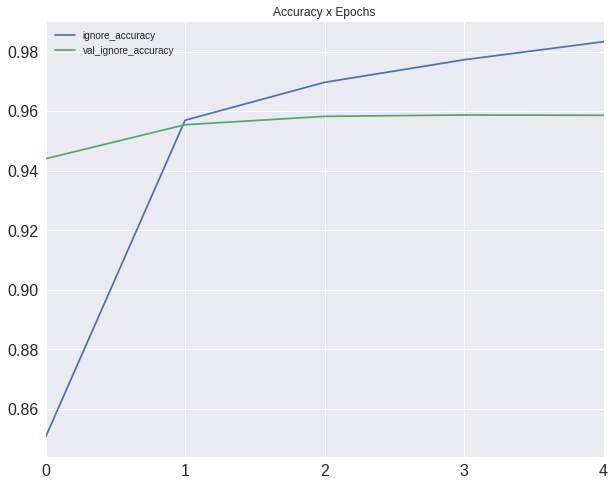

In [210]:
training_log['ignore_accuracy'].plot(legend=True, title='Accuracy x Epochs', xticks=range(training_log.shape[0]),
                                     fontsize=16,xlim=(0,training_log.shape[0]-1))
training_log['val_ignore_accuracy'].plot(figsize=(10,8), legend=True)

In [207]:
test_pred = np.loadtxt('../src/test_predict.txt', dtype=int)

In [96]:
print(classification_report(test_pred.flatten(), test_tags_y.flatten(), target_names=id2tag))

              precision    recall  f1-score   support

       <PAD>       1.00      1.00      1.00     95830
         ADJ       0.89      0.92      0.90      6891
         ADV       0.89      0.90      0.90      4812
      ADV-KS       0.57      0.88      0.69       121
         ART       0.99      0.98      0.98     11447
         CUR       1.00      1.00      1.00       263
          IN       0.63      0.52      0.57       118
          KC       0.98      0.97      0.97      3756
          KS       0.87      0.86      0.87      2333
           N       0.95      0.94      0.95     31999
       NPROP       0.87      0.89      0.88     13377
         NUM       0.94      0.93      0.93      2298
         PCP       0.91      0.95      0.93      2991
        PDEN       0.84      0.91      0.88       857
        PREP       0.97      0.96      0.97     14531
    PREP+ADV       0.86      0.93      0.89        27
    PREP+ART       0.98      0.97      0.97      8788
 PREP+PRO-KS       0.80    

In [176]:
def classification_report_df(report):
    report_data = []
    lines = report.split('\n')
    for line in lines[3:-4]:
        row = {}
        row_data = line.split()
        if not row_data:
            break
        row['class'] = row_data[0]
        row['precision'] = float(row_data[1])
        row['recall'] = float(row_data[2])
        row['f1_score'] = float(row_data[3])
        row['support'] = float(row_data[4])
        report_data.append(row)
    return pd.DataFrame.from_dict(report_data)

In [177]:
df_result_test = classification_report_df(classification_report(test_pred.flatten(), test_tags_y.flatten(), target_names=id2tag))

In [172]:
df_result_test

,class,f1_score,precision,recall,support
1,ADJ,0.90,0.89,0.92,6891.0
2,ADV,0.90,0.89,0.90,4812.0
3,ADV-KS,0.69,0.57,0.88,121.0
4,ART,0.98,0.99,0.98,11447.0
5,CUR,1.00,1.00,1.00,263.0
6,IN,0.57,0.63,0.52,118.0
7,KC,0.97,0.98,0.97,3756.0
8,KS,0.87,0.87,0.86,2333.0
9,N,0.95,0.95,0.94,31999.0
10,NPROP,0.88,0.87,0.89,13377.0


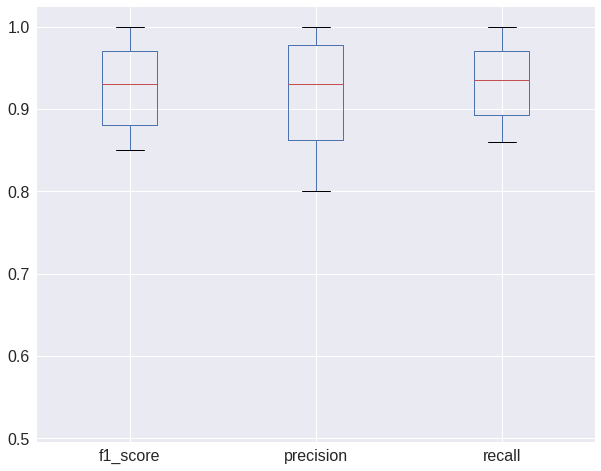

In [178]:
df_result_test.boxplot(column=['f1_score', 'precision', 'recall'], figsize=(10,8), fontsize=16)

In [179]:
df_result_test.describe()

,f1_score,precision,recall,support
count,26.000000,26.000000,26.000000,26.000000
mean,0.908077,0.897692,0.921538,5917.115385
std,0.096417,0.106595,0.092550,8105.863430
min,0.570000,0.570000,0.520000,27.000000
25%,0.880000,0.862500,0.892500,268.750000
50%,0.930000,0.930000,0.935000,2439.500000
75%,0.970000,0.977500,0.970000,8313.750000
max,1.000000,1.000000,1.000000,31999.000000


Text(0.5, 1.0, 'Precision x tag')

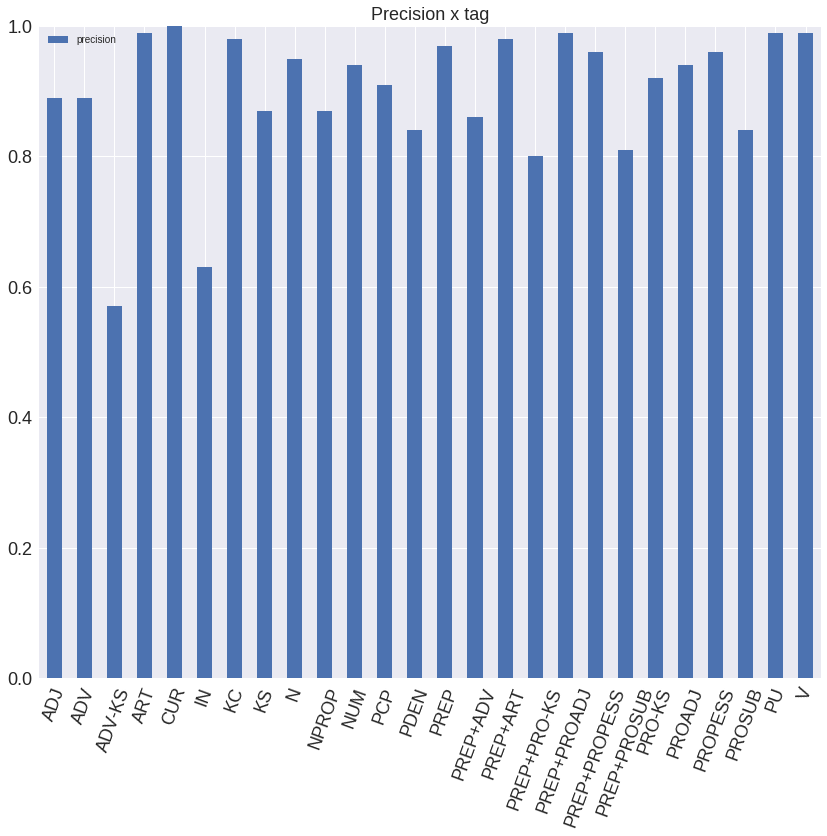

In [202]:
ax = df_result_test.plot.bar(y=['precision'], figsize=(14,12), fontsize=18, use_index=False, ylim=(0,1), rot=70)
ax.set_xticklabels(df_result_test['class'])
ax.set_title('Precision x tag', size=18)

Text(0.5, 1.0, 'Recall x tag')

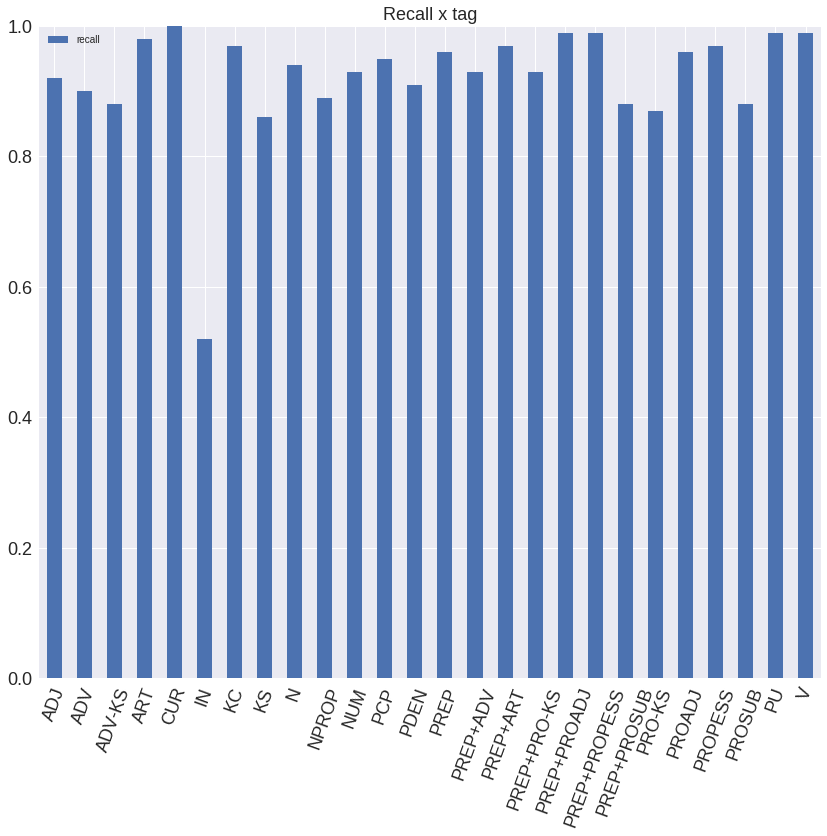

In [203]:
ax = df_result_test.plot.bar(y=['recall'], figsize=(14,12), fontsize=18, use_index=False, ylim=(0,1), rot=70)
ax.set_xticklabels(df_result_test['class'])
ax.set_title('Recall x tag', size=18)

Text(0.5, 1.0, 'f1_score x tag')

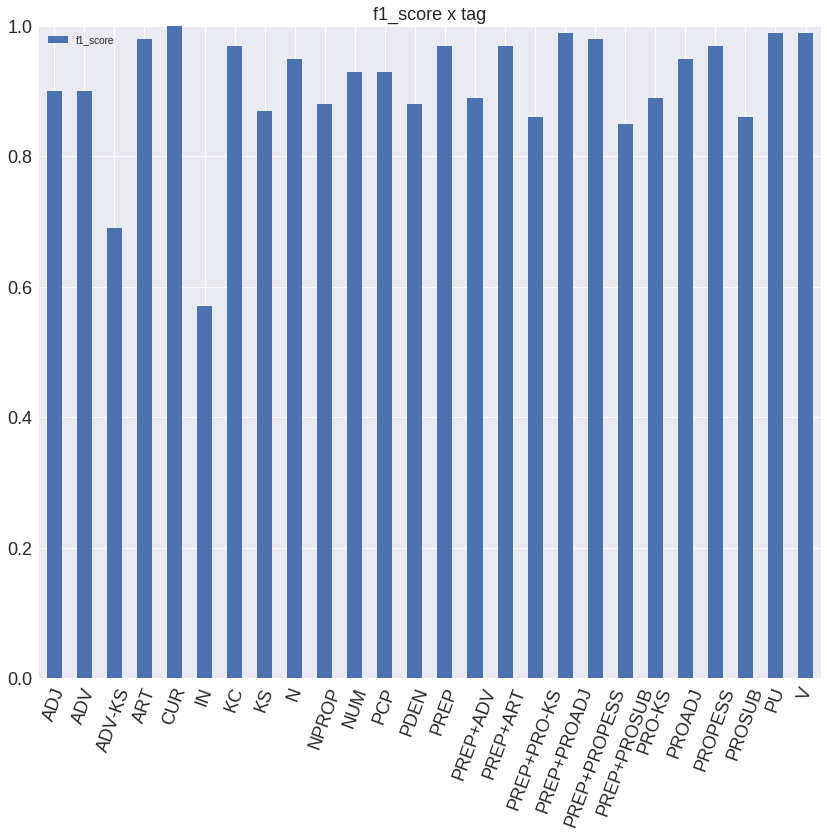

In [204]:
ax = df_result_test.plot.bar(y=['f1_score'], figsize=(14,12), fontsize=18, use_index=False, ylim=(0,1), rot=70)
ax.set_xticklabels(df_result_test['class'])
ax.set_title('f1_score x tag', size=18)

## Referências

1. https://arxiv.org/pdf/1508.01991.pdf
2. http://www.aclweb.org/anthology/Y/Y09/Y09-1013.pdf
3. http://nilc.icmc.usp.br/macmorpho/
4. http://nilc.icmc.usp.br/embeddings
5. http://www.aclweb.org/anthology/P16-2067
6. https://nlpforhackers.io/lstm-pos-tagger-keras/